In [6]:
import torch
import torchvision
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import func

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device: ", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

if device == torch.device('cpu'):
    model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('model.pt'))

model.to(device)

# Test data
test_dataset = func.MaskDataset('data/test_images/')

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=func.collate_fn)

# Training
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = func.make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

# print(labels)
# print(preds_adj_all)
# print(annot_all)

device:  cpu


100%|██████████| 85/85 [21:26<00:00, 15.14s/it]


In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def test_plot_images(img, real, pred):
    
    img = img.permute(1,2,0)
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title("Ground Truth")
    ax1.imshow(img)
    ax2.set_title("Predict")
    ax2.imshow(img)
    
    for idx in range(len(real["boxes"])):
        xmin, ymin, xmax, ymax = real["boxes"][idx]
        if real['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif real['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        ax1.add_patch(rect)
    
    for idx in range(len(pred["boxes"])):
        xmin, ymin, xmax, ymax = pred["boxes"][idx]
        if pred['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif pred['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        ax2.add_patch(rect)
        
#     plt.show()

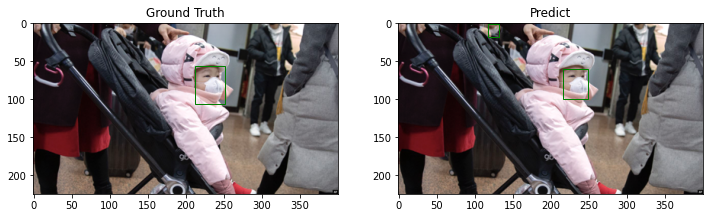

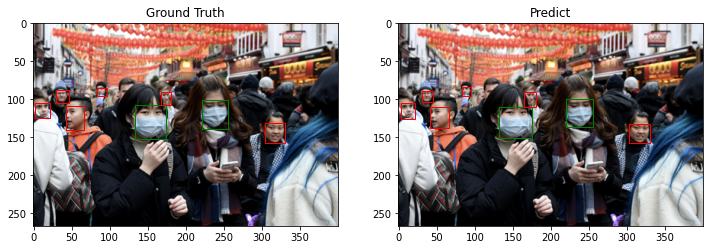

In [8]:
batch_i = 0
for im, annot in test_data_loader:
    for sample_i in range(len(im)):
        test_plot_images(im[sample_i], annot[sample_i], preds_adj_all[batch_i][sample_i])
    batch_i += 1
    if batch_i == 1:
        break

In [ ]:
idx = 0
batch_i = 0
for im, annot in test_data_loader:
    for sample_i in range(len(im)):
        test_plot_images(im[sample_i], annot[sample_i], preds_adj_all[batch_i][sample_i])
    batch_i += 1